In [1]:
# ===============================
# Step 0 – Import thư viện
# ===============================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# ===============================
# Step 1 – Load dữ liệu đã clean và chuẩn hóa numeric
# ===============================
import pandas as pd
import numpy as np

tickers = ["AAPL", "AMZN", "GOOG", "MSFT", "TSLA"]
dfs = {}

for t in tickers:
    df = pd.read_csv(f"../data/processed/clean/{t}.csv", parse_dates=['Date'], index_col='Date')
    df = df.sort_index()  # sắp xếp theo Date tăng dần

    # Convert sang numeric
    df['Price'] = pd.to_numeric(df['Adj Close'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

    # Loại bỏ dòng có giá trị không hợp lệ
    df = df.dropna(subset=['Price', 'Volume'])
    dfs[t] = df

# Kiểm tra
print(dfs['AAPL'].dtypes)
print(dfs['AAPL'].head())

Open          object
High          object
Low           object
Close         object
Adj Close     object
Volume       float64
Ticker        object
Price        float64
dtype: object
                          Open                High                 Low  \
Date                                                                     
2020-11-27  116.56999969482422  117.48999786376953  116.22000122070312   
2020-11-30  116.97000122070312  120.97000122070312  116.80999755859375   
2020-12-01  121.01000213623047  123.47000122070312  120.01000213623047   
2020-12-02   122.0199966430664  123.37000274658203  120.88999938964844   
2020-12-03   123.5199966430664  123.77999877929688  122.20999908447266   

                         Close           Adj Close       Volume Ticker  \
Date                                                                     
2020-11-27  116.58999633789062  113.49478912353516   46691300.0   AAPL   
2020-11-30  119.05000305175781   115.8895034790039  169410200.0   AAPL   
202

In [4]:
# ===============================
# Step 2 – Feature Engineering
# ===============================
def add_features(df):
    # Moving Average
    df['MA5'] = df['Price'].rolling(5).mean()
    df['MA10'] = df['Price'].rolling(10).mean()
    df['MA20'] = df['Price'].rolling(20).mean()
    
    # RSI
    delta = df['Price'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    RS = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + RS))
    
    # MACD
    EMA12 = df['Price'].ewm(span=12, adjust=False).mean()
    EMA26 = df['Price'].ewm(span=26, adjust=False).mean()
    df['MACD'] = EMA12 - EMA26
    
    # Volume change
    df['Vol_change'] = df['Volume'].pct_change()
    
    # Target cho ML
    df['y_reg'] = df['Price'].shift(-1)  # Regression: giá ngày mai
    df['y_clf'] = (df['Price'].shift(-1) > df['Price']).astype(int)  # Classification: tăng/giảm
    
    # Loại bỏ NaN sinh ra bởi rolling và shift
    df = df.dropna()
    return df

# Thêm feature cho từng ticker
for t in tickers:
    dfs[t] = add_features(dfs[t])

# Kiểm tra
print(dfs['AAPL'].head())
print(dfs['AAPL'].dtypes)

                          Open                High                 Low  \
Date                                                                     
2020-12-24  131.32000732421875   133.4600067138672  131.10000610351562   
2020-12-28  133.99000549316406  137.33999633789062  133.50999450683594   
2020-12-29   138.0500030517578   138.7899932861328  134.33999633789062   
2020-12-30   135.5800018310547  135.99000549316406  133.39999389648438   
2020-12-31   134.0800018310547  134.74000549316406  131.72000122070312   

                         Close           Adj Close       Volume Ticker  \
Date                                                                     
2020-12-24  131.97000122070312   128.4665069580078   54930100.0   AAPL   
2020-12-28  136.69000244140625   133.0612030029297  124486200.0   AAPL   
2020-12-29   134.8699951171875   131.2895050048828  121047300.0   AAPL   
2020-12-30  133.72000122070312   130.1699981689453   96452100.0   AAPL   
2020-12-31  132.69000244140625  129.1

In [5]:
# ===============================
# Step 3 – Chuẩn bị dữ liệu ML
# ===============================
features = ['Price', 'MA5', 'MA10', 'MA20', 'RSI', 'MACD', 'Vol_change']

def prepare_data(df):
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Regression
    y_reg = df['y_reg']
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_scaled, y_reg, test_size=0.2, shuffle=False
    )
    
    # Classification
    y_clf = df['y_clf']
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
        X_scaled, y_clf, test_size=0.2, shuffle=False
    )
    
    return X_train_reg, X_test_reg, y_train_reg, y_test_reg, X_train_clf, X_test_clf, y_train_clf, y_test_clf

data_prepared = {}
for t in tickers:
    data_prepared[t] = prepare_data(dfs[t])

In [6]:
# ===============================
# Step 4 – Regression Models
# ===============================
def regression_models(X_train, X_test, y_train, y_test):
    results = {}
    
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    results['LinearRegression'] = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    
    # Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    results['RandomForest'] = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    
    # XGBoost
    xgbr = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgbr.fit(X_train, y_train)
    y_pred_xgb = xgbr.predict(X_test)
    results['XGBoost'] = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    
    return results

for t in tickers:
    X_train_reg, X_test_reg, y_train_reg, y_test_reg, *_ = data_prepared[t]
    res = regression_models(X_train_reg, X_test_reg, y_train_reg, y_test_reg)
    print(f"{t} Regression RMSE:", res)


AAPL Regression RMSE: {'LinearRegression': np.float64(4.3553162099444505), 'RandomForest': np.float64(16.137473990300293), 'XGBoost': np.float64(17.84790563657359)}
AMZN Regression RMSE: {'LinearRegression': np.float64(4.615963808515705), 'RandomForest': np.float64(19.673162694374184), 'XGBoost': np.float64(20.148405458665188)}
GOOG Regression RMSE: {'LinearRegression': np.float64(4.3432120770394365), 'RandomForest': np.float64(38.98529578826196), 'XGBoost': np.float64(41.61487477495903)}
MSFT Regression RMSE: {'LinearRegression': np.float64(6.610536617364379), 'RandomForest': np.float64(43.493344849451226), 'XGBoost': np.float64(45.01073797793602)}
TSLA Regression RMSE: {'LinearRegression': np.float64(13.645138021746384), 'RandomForest': np.float64(34.66236203370434), 'XGBoost': np.float64(50.571698358275825)}


In [7]:
# ===============================
# Step 5 – Classification Models
# ===============================
def classification_models(X_train, X_test, y_train, y_test):
    results = {}
    
    # Logistic Regression
    log = LogisticRegression()
    log.fit(X_train, y_train)
    y_pred_log = log.predict(X_test)
    results['LogisticRegression'] = {
        'Accuracy': accuracy_score(y_test, y_pred_log),
        'Precision': precision_score(y_test, y_pred_log),
        'Recall': recall_score(y_test, y_pred_log)
    }
    
    # Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    results['RandomForest'] = {
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'Precision': precision_score(y_test, y_pred_rf),
        'Recall': recall_score(y_test, y_pred_rf)
    }
    
    return results

for t in tickers:
    _, _, _, _, X_train_clf, X_test_clf, y_train_clf, y_test_clf = data_prepared[t]
    res = classification_models(X_train_clf, X_test_clf, y_train_clf, y_test_clf)
    print(f"{t} Classification Metrics:", res)

AAPL Classification Metrics: {'LogisticRegression': {'Accuracy': 0.5344129554655871, 'Precision': 0.5407725321888412, 'Recall': 0.9402985074626866}, 'RandomForest': {'Accuracy': 0.4777327935222672, 'Precision': 0.5221238938053098, 'Recall': 0.44029850746268656}}
AMZN Classification Metrics: {'LogisticRegression': {'Accuracy': 0.4898785425101215, 'Precision': 0.5194805194805194, 'Recall': 0.31007751937984496}, 'RandomForest': {'Accuracy': 0.4331983805668016, 'Precision': 0.3877551020408163, 'Recall': 0.14728682170542637}}
GOOG Classification Metrics: {'LogisticRegression': {'Accuracy': 0.5506072874493927, 'Precision': 0.5495867768595041, 'Recall': 0.9851851851851852}, 'RandomForest': {'Accuracy': 0.4898785425101215, 'Precision': 0.5529411764705883, 'Recall': 0.34814814814814815}}
MSFT Classification Metrics: {'LogisticRegression': {'Accuracy': 0.4898785425101215, 'Precision': 0.515625, 'Recall': 0.75}, 'RandomForest': {'Accuracy': 0.46558704453441296, 'Precision': 0.5, 'Recall': 0.34090

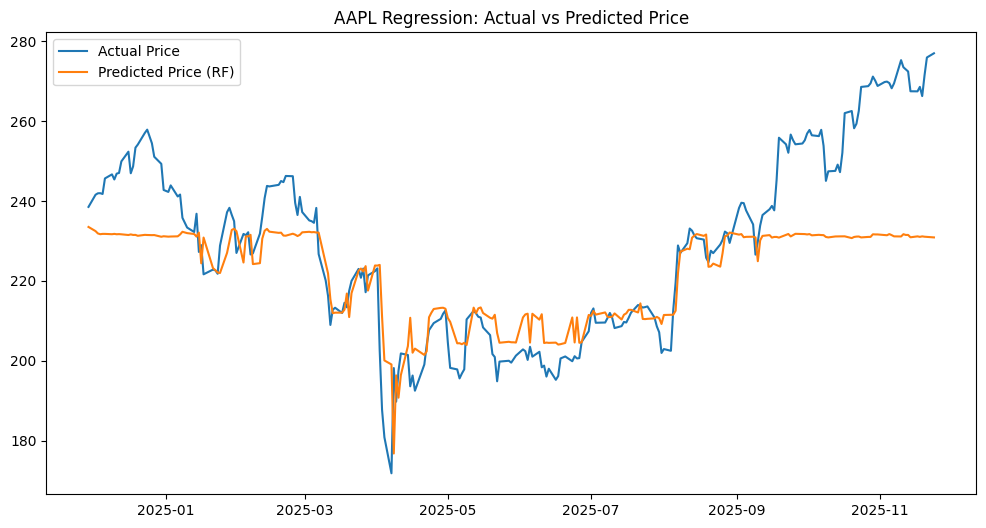

In [8]:
# ===============================
# Step 6 – Visualization ví dụ Regression
# ===============================
ticker = "AAPL"
X_train_reg, X_test_reg, y_train_reg, y_test_reg, *_ = data_prepared[ticker]
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_reg, y_train_reg)
y_pred_rf = rf_model.predict(X_test_reg)

plt.figure(figsize=(12,6))
plt.plot(dfs[ticker].index[-len(y_test_reg):], y_test_reg, label='Actual Price')
plt.plot(dfs[ticker].index[-len(y_test_reg):], y_pred_rf, label='Predicted Price (RF)')
plt.legend()
plt.title(f"{ticker} Regression: Actual vs Predicted Price")
plt.show()

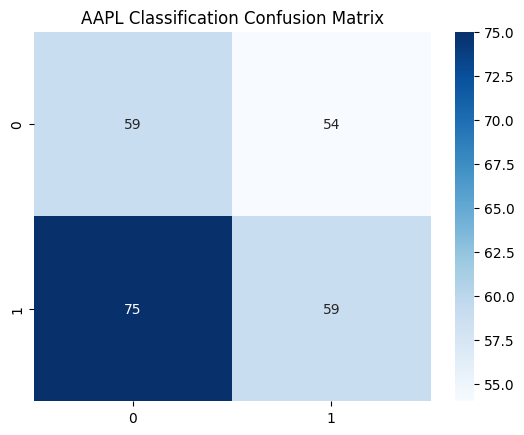

In [9]:
# ===============================
# Step 7 – Classification confusion matrix ví dụ
# ===============================
_, _, _, _, X_train_clf, X_test_clf, y_train_clf, y_test_clf = data_prepared[ticker]
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_clf, y_train_clf)
y_pred_rf_clf = rf_clf.predict(X_test_clf)

cm = confusion_matrix(y_test_clf, y_pred_rf_clf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"{ticker} Classification Confusion Matrix")
plt.show()